## Notebook Overview

This notebook builds upon the prepared data from the previous notebook (`02_feature_selection_and_preparation.ipynb`) and focuses on **Exploratory Data Analysis (EDA)**. This stage involves gaining a deeper understanding of the data through visualizations, summary statistics, and various analytical techniques. The insights gained from EDA will inform subsequent feature engineering, model selection, and interpretation of results.

### 0.3.1 Objectives

The main objectives of this notebook are:

1. **Understand Data Distributions:** Visualize the distributions of individual features (numerical and categorical) to identify patterns, outliers, and potential data quality issues.
2. **Explore Feature Relationships:** Analyze the relationships between features and the target variable (loan default) to identify potential predictors and understand their influence.
3. **Identify Key Insights:** Uncover patterns, trends, and anomalies in the data that can provide valuable insights for building effective credit risk models.
4. **Inform Feature Engineering and Modeling:** Use the insights gained from EDA to guide further feature engineering efforts and inform the selection of appropriate machine learning models.

### 0.3.2 Importance of Exploratory Data Analysis

EDA plays a vital role in the success of a machine learning project for several reasons:

- **Data Understanding:** EDA helps us gain a deeper understanding of the data's structure, characteristics, and potential issues.
- **Feature Selection:** EDA can reveal which features are most relevant to the target variable and guide feature engineering efforts.
- **Model Selection:** EDA can provide insights into the types of machine learning models that might be most suitable for the data.
- **Problem Identification:** EDA can help identify potential problems with the data, such as missing values, outliers, or inconsistencies.
- **Insight Generation:** EDA can uncover hidden patterns, trends, and relationships in the data that can lead to valuable business insights.

### 0.3.3 Our Approach

In this notebook, we will employ a variety of EDA techniques, including:

- **Summary Statistics:** Calculate descriptive statistics (mean, median, standard deviation, etc.) for numerical features to understand their central tendency and spread.
- **Histograms and Box Plots:** Visualize the distributions of numerical features to identify skewness, outliers, and potential data transformations needed.
- **Bar Charts:** Explore the frequencies and proportions of categorical features to understand their representation in the dataset.
- **Scatter Plots and Correlation Matrices:** Analyze the relationships between numerical features and the target variable to identify potential predictors and understand their correlations.
- **Cross-Tabulations:** Examine the relationships between categorical features and the target variable to identify potential patterns and associations.

In [1]:
import polars as pl
from IPython.display import Image

from retail_bank_risk.basic_visualizations_utils import (
    plot_single_bar_chart,
    plot_combined_histograms,
    plot_categorical_features_by_target,
)

from retail_bank_risk.data_preprocessing_utils import(
    create_stratified_sample
)

In [2]:
application_train = pl.read_parquet(
    "../data/processed/application_train_prepared.parquet"
)
application_test = pl.read_parquet(
    "../data/processed/application_test_prepared.parquet"
)

As we have loaded our data, let's display basic summary statistics for our dataset to get an overview of the distribution of our numerical features.

In [3]:
numerical_dtypes = [pl.Float32, pl.Float64, pl.Int8, pl.Int16, pl.Int32]
numerical_reduced_train = application_train.select(pl.col(numerical_dtypes))

numerical_reduced_train.describe()

statistic,days_last_phone_change,ext_source_2,ext_source_3,days_id_publish,days_birth,amt_income_total,amt_credit,amt_annuity,amt_goods_price
str,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",307511.0,307511.0,307511.0,307511.0,307511.0,307511.0,307511.0,307511.0,307511.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",-962.859565,0.514371,0.510876,-2994.202373,-16036.995067,168797.919297,599025.999706,27108.50841,538160.425796
"""std""",826.807255,0.190907,0.180385,1509.450419,4363.988632,237123.146279,402490.776996,14493.617377,369404.535394
"""min""",-4292.0,8.1736e-8,0.000527,-7197.0,-25229.0,25650.0,45000.0,1615.5,40500.0
"""25%""",-1570.0,0.392702,0.392774,-4299.0,-19682.0,112500.0,270000.0,16524.0,238500.0
"""50%""",-757.0,0.565763,0.528093,-3254.0,-15750.0,147150.0,513531.0,24903.0,450000.0
"""75%""",-274.0,0.663461,0.647977,-1720.0,-12413.0,202500.0,808650.0,34596.0,679500.0
"""max""",0.0,0.855,0.89601,0.0,-7489.0,1.17e8,4.05e6,258025.5,4.05e6


**Time-Related Features (days):**

- Generally skewed towards more recent events (phone/ID changes).

**External Source Scores:**

- Slightly left-skewed, potentially indicating a tendency towards higher scores.
  Financial Features:
- Income, loan amount, annuity, and goods price are all right-skewed.
- This indicates a small number of applicants with very high values.
- Suggests potential need for data transformations (e.g., log transformation) and outlier handling to improve model performance.

**Key Takeaways:**

- Time-related features might reveal insights into creditworthiness based on the recency of events.
- Skewed financial features require careful consideration during analysis and modeling.

**Next**, we can visualize feature distributions **using a stratified sample of 10,000 rows to ensure representation of both classes in our imbalanced target variable.**

In [4]:
pd_application_train = create_stratified_sample(application_train, 'target', 10000)
pd_application_test = application_test.to_pandas()

In [5]:
target_feature = "target"

In [6]:
numerical_features_financial = [
    "ext_source_2",
    "ext_source_3",
    "amt_income_total",
    "amt_credit",
]

numerical_features_loan_specifics = ["amt_annuity", "amt_goods_price"]

numerical_features_timing_history = [
    "days_last_phone_change",
    "days_birth",
    "days_id_publish",
]

With our features grouped, we can begin visualizing their distributions, starting with an analysis of the target variable.

In [7]:
plot_single_bar_chart(pd_application_train, "target", save_path="../images/target_distribution.png")

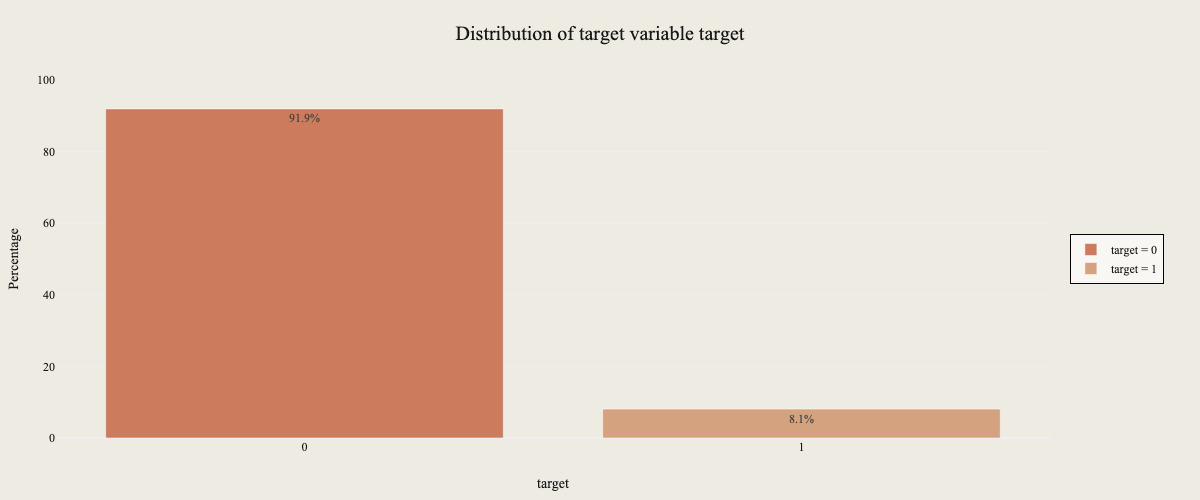

In [8]:
Image(filename="../images/target_distribution.png")

Due to the significant class imbalance in the target variable, we will visualize the distribution of numerical features using the entire dataset, rather than comparing distributions separately for each target class.

In [9]:
plot_combined_histograms(
    application_train,
    numerical_features_financial,
    save_path="../images/numerical_features_financial.png",
)

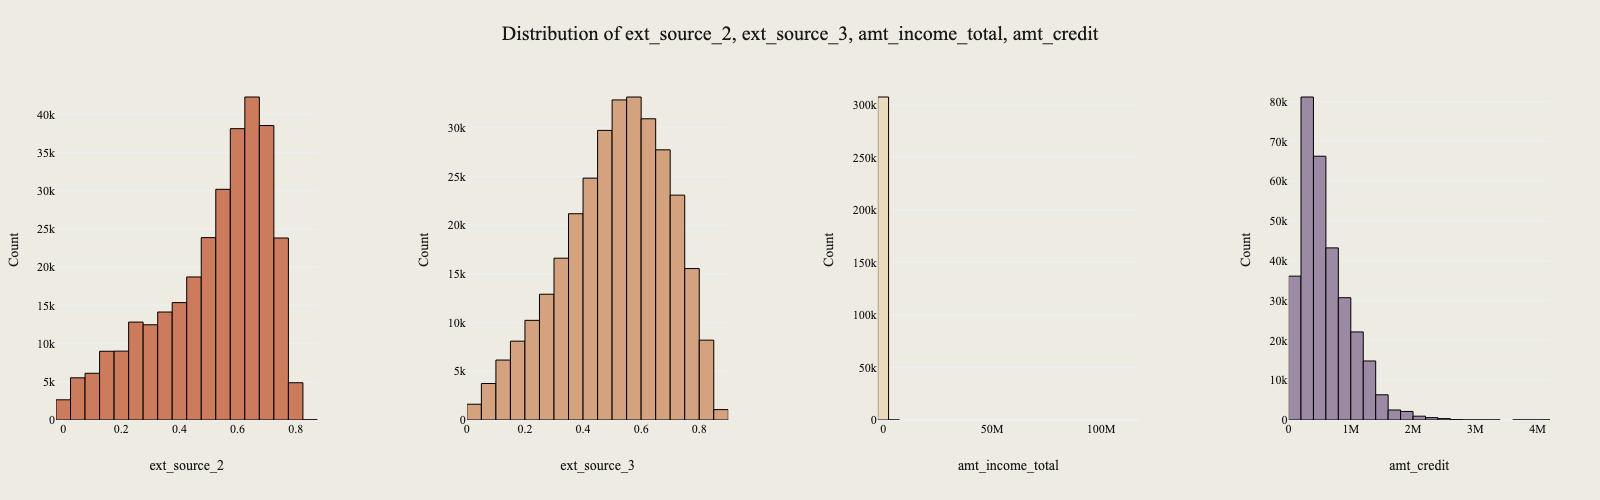

In [10]:
Image(filename="../images/numerical_features_financial.png")

- **ext_source_2 & ext_source_3:** Both show a somewhat normal distribution, but with a peak towards the lower end of their values. This suggests these external sources might have a bias towards lower scores.
- **amt_income_total:** Heavily skewed to the right, indicating most incomes are clustered at the lower end with a few very high earners.
- **amt_credit:** Also right-skewed, meaning most loans are for smaller amounts, with a long tail of larger loans.

In [11]:
plot_combined_histograms(
    pd_application_train,
    numerical_features_loan_specifics,
    save_path="../images/numerical_features_loan_specifics.png",
)

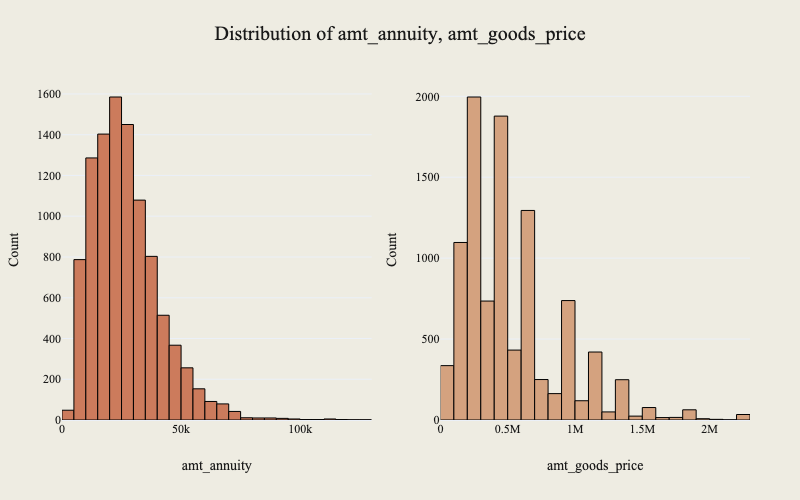

In [12]:
Image(filename="../images/numerical_features_loan_specifics.png")

- **amt_annuity:** Right-skewed, suggesting most loan annuity payments are smaller, with a few much larger payments.
- **amt_goods_price:** Right-skewed as well, indicating most loans are for lower-priced goods, with a tail of loans for more expensive items.

In [13]:
plot_combined_histograms(
    pd_application_train,
    numerical_features_timing_history,
    save_path="../images/numerical_features_timing_history.png",
)

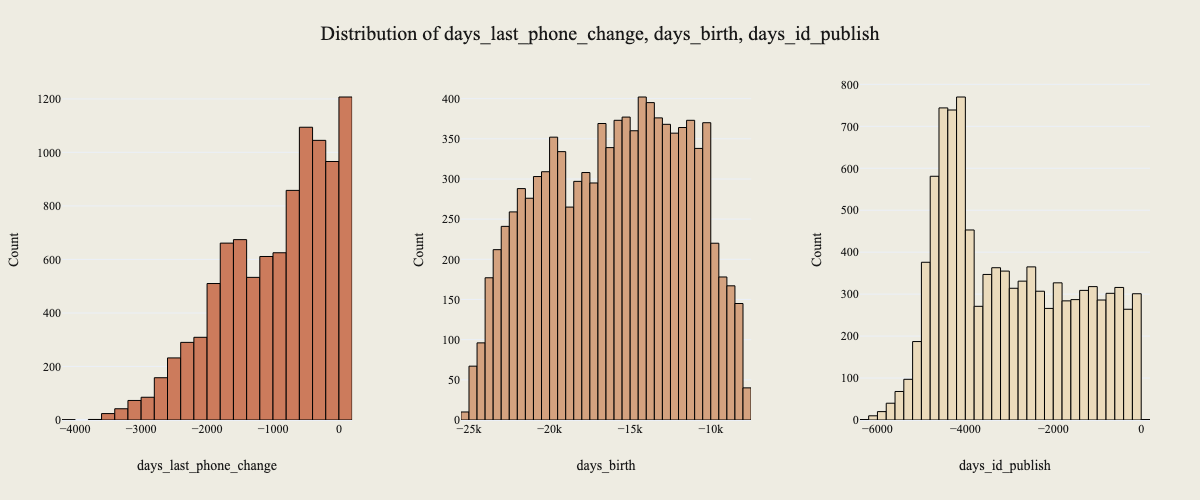

In [14]:
Image(filename="../images/numerical_features_timing_history.png")

- **days_last_phone_change:** Mostly clustered towards more recent phone changes (closer to 0), with a sharp drop-off for older changes.
- **days_birth:** Shows the age distribution of loan applicants, with a peak around middle age. The negative values represent days before the loan application.
- **days_id_publish:** Right-skewed, indicating most applicants provided their ID relatively recently before the loan application.

General observations:

- **Right Skew:** Many of the financial features (income, credit, annuity, goods price) are right-skewed, which is common in financial data. This indicates a concentration of lower values with a few high-value outliers.
- **External Sources:** The distribution of `ext_source_2` and `ext_source_3` suggests potential bias in these external scoring systems.
- **Time-Based Features:** The distributions of `days_last_phone_change`, `days_birth`, and `days_id_publish` provide insights into the recency of actions and the age distribution of applicants.

**Next up**, let's examine the distributions of our categorical features.

In [15]:
categorical_features_personal = [
    "name_contract_type",
    "code_gender",
    "flag_own_car",
    "flag_own_realty",
]

categorical_features_housing_family = [
    "name_type_suite",
    "name_income_type",
    "name_education_type",
    "name_family_status",
]

categorical_features_occupation = [
    "name_housing_type",
    "occupation_type",
    "housetype_mode",
    "emergencystate_mode",
]

categorical_features_work_context = [
    "weekday_appr_process_start",
    "organization_type",
    "reg_city_not_work_city",
]

categorical_features_ratings = [
    "region_rating_client",
    "region_rating_client_w_city",
    ""
]

In [16]:
all_categorical_features = (
    categorical_features_personal
    + categorical_features_housing_family
    + categorical_features_occupation
    + categorical_features_work_context
    + categorical_features_ratings
)

all_numerical_features = (
    numerical_features_timing_history
    + numerical_features_financial
    + numerical_features_loan_specifics
)

all_features = all_categorical_features + all_numerical_features

In [17]:
plot_categorical_features_by_target(pd_application_train, categorical_features_personal,target_feature)